In [4]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [80]:
MAX_FREQS_PER_STAR = 10

In [82]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [7]:
#array of time differences, find its median, use it to calculate the max frequency
lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days_no_units)
print(f_max_no_units)
print(sampling_rate_days)



0.02043360086827306
48.93900034783809
0.02043360086827306


In [10]:
#check there is no unit
print(type(f_max_no_units), type(sampling_rate_days_no_units))


<class 'numpy.float64'> <class 'numpy.float64'>


In [12]:
#find total observation time, use it to find minimum frequency
total_observation_time = lc.time[-1] - lc.time[0] # in days
f_min = f_min = 1/ total_observation_time # in days
f_min_no_units = f_min.value #strip units (but are in 1/days)
print(f_min_no_units)
print(type(f_min_no_units))

0.0006800582572566702
<class 'numpy.float64'>


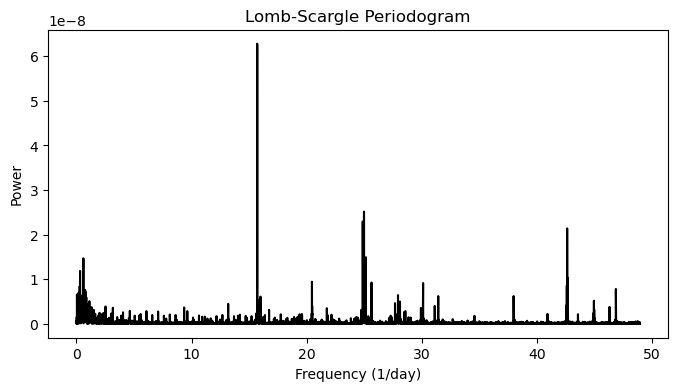

In [13]:
#trying to create periodograms with no units by manually plotting
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    minimum_frequency=f_min_no_units,
    maximum_frequency=f_max_no_units
)

power_no_units = np.array(pg.power.value)
freq_no_units = np.array(pg.frequency.value)
plt.figure(figsize=(8, 4))
plt.plot(freq_no_units, power_no_units, 'k-')  # Black line
plt.xlabel("Frequency (1/day)") 
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()



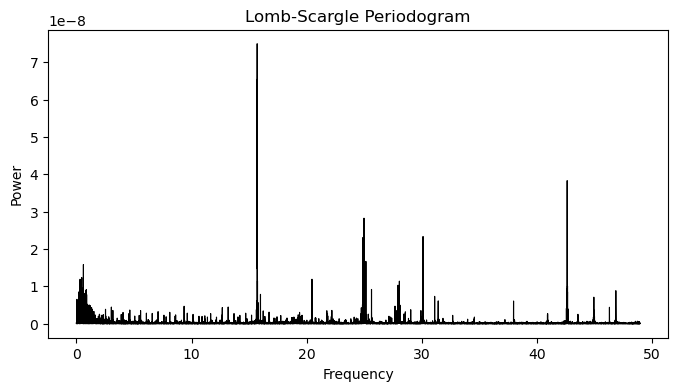

In [14]:
#trying to create periodograms of spacing f_min
frequency_grid = np.arange(f_min_no_units, f_max_no_units, f_min_no_units) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8) 
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()




In [42]:
def find_nanapeaks(num_of_peaks, xs, ys): 
    """
    
    reorders them from high peak to lowest peaks
    
    """
    indxs, properties = find_peaks(ys)
    sindx = np.argsort(-ys[indxs])[:num_of_peaks]
    return (xs[indxs[sindx]], ys[indxs[sindx]],indxs[sindx])

In [52]:
freq_peak_vals, power_peak_vals, peak_index = find_nanapeaks(MAX_FREQS_PER_STAR, freq_values, power_values)
print(freq_peak_vals,power_peak_vals,peak_index)

[15.7018651  15.71206598 42.61789087 24.97717967 30.10345882 24.86565012
 25.14243383  0.61545272  0.46992026 20.45955267] [7.49986831e-08 6.54941834e-08 3.83273169e-08 2.82630506e-08
 2.33619709e-08 2.30438533e-08 1.66955653e-08 1.58455420e-08
 1.23652101e-08 1.19152373e-08] [23088 23103 62667 36727 44265 36563 36970   904   690 30084]


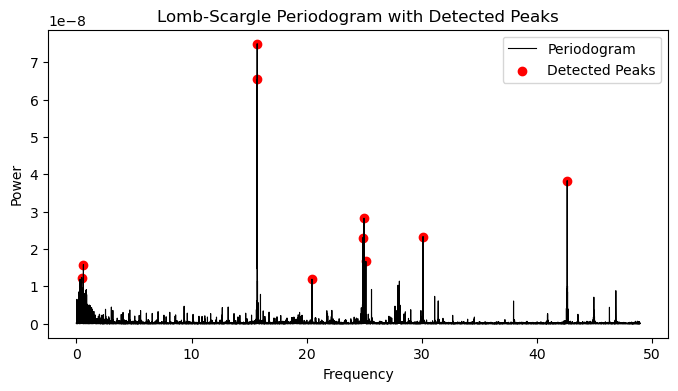

In [48]:
#marking the peaks that we found

plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k-', lw=0.8, label="Periodogram")

plt.scatter(freq_peak_vals, power_peak_vals, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()


In [38]:
print(freq_values)

[6.80058257e-04 1.36011651e-03 2.04017477e-03 ... 4.89369922e+01
 4.89376723e+01 4.89383523e+01]


In [99]:
##All the methods for peak refining yay!!!!

def check_inputs(xs):
    """
    
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """

    
    """
    return(xs[np.argsort(xs)], ys[np.argsort(xs)])
    

def create_design_matrix(xlist): #assumes that xs are ordered
    """
    """
    #print("This is xlist:", xlist)
    return((np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T)

def fit_parabola(xs, ys, index):
    """
    """
    A = create_design_matrix(np.array([xs[index-1], xs[index], xs[index+1]]))
    #print("This is shape of design matrix:", A.shape)
    B = np.vstack((ys[index-1],ys[index], ys[index+1])).reshape(-1, 1)
    #print("This is the shape of the other matrix:", B.shape)
    return np.linalg.solve(create_design_matrix(np.array([xs[index-1], xs[index], xs[index+1]])), np.vstack((ys[index-1],ys[index], ys[index+1])).reshape(-1, 1))

def refine_peak(xs, ys, index):
    """
    """
    b,m,q = fit_parabola(xs, ys, index)
    return -m/q,0.5*q*(-m/q)**2+m*(-m/q)+b

In [101]:
check_inputs(freq_values)

True

In [113]:
xs_refined = np.array([])
ys_refined = np.array([])
for i in peak_index:
    xs_new, ys_new = refine_peak(freq_values, power_values, i)
    xs_refined = np.append(xs_refined, xs_new)
    ys_refined = np.append(ys_refined,ys_new)
print("This is the refined frequencies:", xs_refined, "\nThis is the refined powers:", ys_refined)

This is the refined frequencies: [15.70184503 15.71217506 42.61760861 24.9770961  30.10343601 24.86568309
 25.14225572  0.61572691  0.46996823 20.45969442] 
This is the refined powers: [7.50007976e-08 6.55488932e-08 3.85119572e-08 2.82718702e-08
 2.33626489e-08 2.30454510e-08 1.67248546e-08 1.59238917e-08
 1.23673035e-08 1.19277569e-08]


In [117]:
print("This is the original frequencies:" freq_peak_vals, "\n this is the original powers:", power_peak_vals)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1357982797.py, line 1)